In [9]:
%%capture
## compile PyRossTSI for this notebook
import os
owd = os.getcwd()
os.chdir('../..')
%run setup.py install
os.chdir(owd)

In [10]:
import pyrosstsi
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [11]:
T = 15                                       # Longest  infectious duration
Td = 5                                       # Doubling time in linear growth regime
Tf = 150                                     # Duration of simulation

tsi  = np.array([0,   3,    5,   10,   T])   # Time since infection (days)
beta = np.array([0,   0.5,  1,   .5,   0])   # Mean infectiousness 
tsi_sc=np.array([0,3.,6., 9.,   12,    T]) 

M = 2                                        # Number of age groups to model
Ni = 10**6*np.ones(M)                        # Number of people in each age group
Np = sum(Ni)                                 # Total population size

subclasses = ['Recovered', 'Hospitalized', 'Mortality']  
Nc = len(subclasses)
Nk = 10                #Number of stages in Predictor/Corrector method
Tc = T/2               

def contactMatrix(t):    return np.array([[4, 1],[1, 2]]); 

In [12]:
parameters = {'M':M, 'Ni':Ni, 'Nc':Nc, 'Nk':Nk, 'Tf':Tf, 'Tc':Tc, 'T':T, 'Td':Td,
              'tsi':tsi,'beta':beta,'tsi_sc':tsi_sc,'contactMatrix':contactMatrix}

model = pyrosstsi.deterministic.Simulator(parameters, subclasses)
IC    = model.get_IC()
data  = model.integrate(IC)

(0.0, 17694.856984503815)

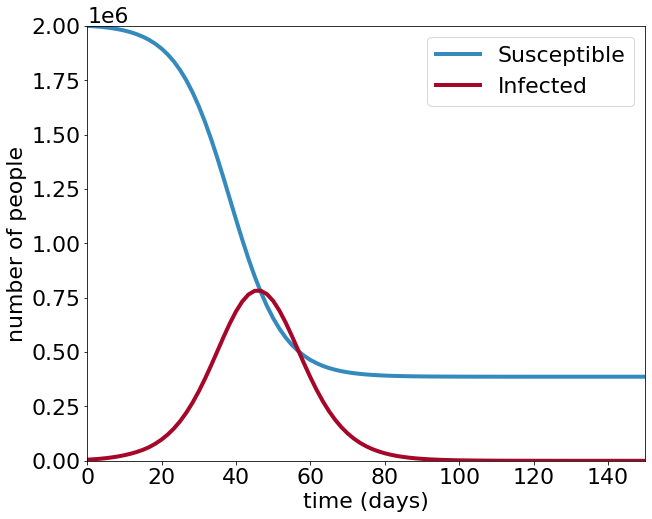

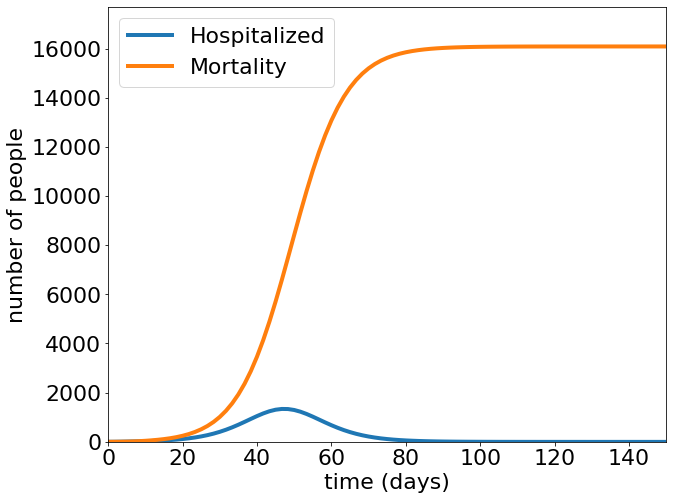

In [16]:
t = data['t']; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 

plt.figure(figsize=(10, 8)) 
plt.plot(t*Tc,Np*np.sum(S_t,0), color="#348ABD", lw=4, label = 'Susceptible')           #all susceptible
plt.plot(t*Tc,Np*np.sum(I_t,0), color="#A60628", lw=4, label = 'Infected')              #all Infected
plt.xlabel('time (days)');       plt.xlim(0,Tf); plt.rcParams.update({'font.size': 22})
plt.ylabel('number of people');  plt.ylim(0,Np); plt.legend()

plt.figure(figsize=(10, 8)) 
for i in (1 + np.arange(Nc-1)):
    plt.plot(Tc*t,Np*np.sum(Ic_t[i,:,:],0), lw=4, label = subclasses[i])
plt.legend(); plt.xlabel('time (days)'); plt.ylabel('number of people')
plt.xlabel('time (days)');       plt.xlim(0,Tf)
plt.ylabel('number of people');  plt.ylim(0,1.1*np.amax(Np*np.sum(Ic_t[2,:,:],0)))